## Import Library

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import time
from torch.autograd import Variable
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Data Preparation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_path='/content/drive/MyDrive/Datasets'

In [4]:
os.listdir(data_path)

['gender_classification.csv',
 'list_attribute.txt',
 'class_identity.txt',
 'Images',
 'README.gdoc']

In [5]:
#!ls '/content/drive/MyDrive/FaceRecognition/Datasets/Images'

In [6]:
# Load data from a CSV file
data = pd.read_csv(os.path.join(data_path, 'gender_classification.csv'))

# Split the data into train and test sets with a 80:20 ratio
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [7]:
data.columns = ["image_path", "Male"]

data

,image_path,Male
0,000041.jpg,1
1,000044.jpg,0
2,000047.jpg,0
3,000050.jpg,1
4,000063.jpg,0
...,...,...
9995,202548.jpg,0
9996,202554.jpg,1
9997,202557.jpg,0
9998,202566.jpg,1


## Preprocessing

In [8]:
class GenderDataset(Dataset):
    def __init__(self, data, image_folder_path, transform=None):
        self.data = data
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder_path, self.data.iloc[idx, 0])
        image = Image.open(image_path).convert('RGB')
        gender = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(gender, dtype=torch.long)

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [10]:
train_set = GenderDataset(train_data, image_folder_path=os.path.join(data_path, "Images"), transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)

test_set = GenderDataset(test_data, os.path.join(data_path, "Images"), transform=transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

## Architecture

In [11]:
# please Define the model optimizer and criterion (loss function)
model = models.vgg16()
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 2)

use_gpu = torch.cuda.is_available()

if use_gpu:
  model = model.to("cuda")

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [12]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Modeling

In [13]:
import time
from torch.autograd import Variable

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu=torch.cuda.is_available(), num_epochs=20):
    #please define the training model here
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    history = {'train': {'acc': [], 'loss': []}, 'test': {'acc': [], 'loss': []}}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            history[phase]['acc'].append(epoch_acc.detach().cpu())
            history[phase]['loss'].append(epoch_loss.detach().cpu())

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [14]:
dataloaders = {
    "train":train_loader, "test":test_loader
}
dataset_sizes= {
    "train":len(train_set), "test":len(test_set)
}

In [15]:
use_gpu = torch.cuda.is_available()

if use_gpu:
  model = model.to("cuda")

In [16]:
model, history = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu, 10)

Epoch 0/9
----------
train Loss: 0.0105 Acc: 0.5888
test Loss: 0.0096 Acc: 0.6655

Epoch 1/9
----------
train Loss: 0.0089 Acc: 0.7038
test Loss: 0.0087 Acc: 0.7200

Epoch 2/9
----------
train Loss: 0.0076 Acc: 0.7696
test Loss: 0.0071 Acc: 0.7900

Epoch 3/9
----------
train Loss: 0.0060 Acc: 0.8306
test Loss: 0.0049 Acc: 0.8680

Epoch 4/9
----------
train Loss: 0.0045 Acc: 0.8806
test Loss: 0.0040 Acc: 0.8950

Epoch 5/9
----------
train Loss: 0.0032 Acc: 0.9144
test Loss: 0.0031 Acc: 0.9295

Epoch 6/9
----------
train Loss: 0.0025 Acc: 0.9378
test Loss: 0.0028 Acc: 0.9290

Epoch 7/9
----------
train Loss: 0.0020 Acc: 0.9509
test Loss: 0.0024 Acc: 0.9455

Epoch 8/9
----------
train Loss: 0.0017 Acc: 0.9585
test Loss: 0.0026 Acc: 0.9450

Epoch 9/9
----------
train Loss: 0.0014 Acc: 0.9641
test Loss: 0.0025 Acc: 0.9465

Training complete in 33m 45s
Best test Acc: 0.946500


## Evaluation

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)

    print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_accuracy:.2f}')
    
    return val_loss, val_accuracy

In [19]:
def evaluate_model(model, test_loader, class_names):
    was_training = model.training
    model.eval()

    CM = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            CM += confusion_matrix(labels.cpu(), preds.cpu(), labels = [0,1])

            model.train(mode=was_training)

        model.train(mode=was_training)

        tn = CM[0][0]
        tp = CM[1][1]
        fp = CM[0][1]
        fn = CM[1][0]

        acc = (tp + tn) / (tp + tn + fp + fn)
        recall=tp/(tp+fn)
        precision=tp/(tp+fp)
        f1_score = ((2*recall*precision)/(recall+precision))

        print(f"Accuracy : {acc:.4f}")
        print(f"Recall : {recall:.4f}")
        print(f"Precision : {precision:.4f}")
        print(f"F1_Score : {f1_score:.4f}")

        # Plot the confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=CM,
                              display_labels=class_names)
        disp.plot()


Accuracy : 0.9465
Recall : 0.9186
Precision : 0.9497
F1_Score : 0.9339


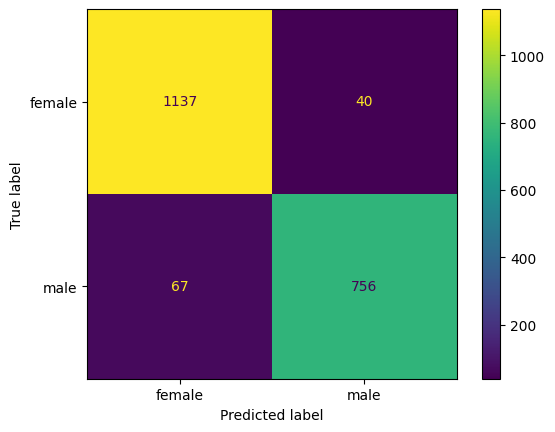

In [20]:
evaluate_model(model, dataloaders['test'], ["female", "male"])

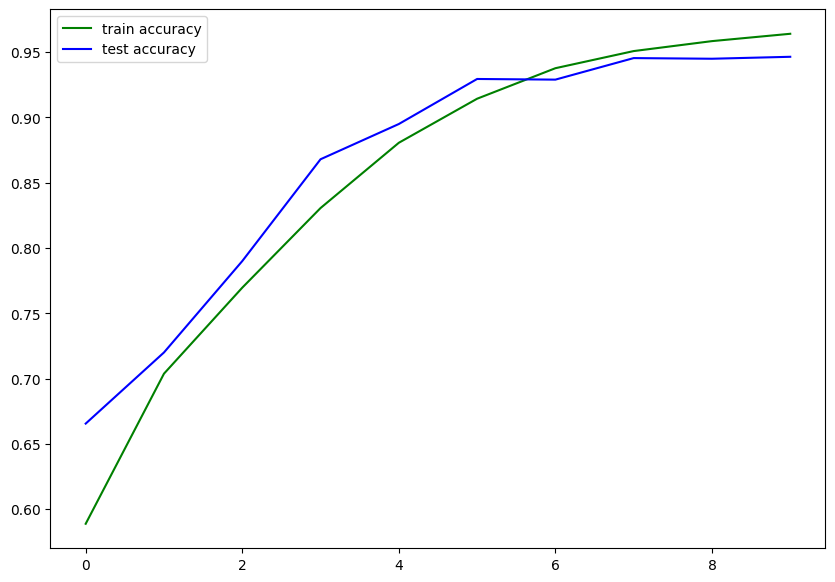

In [21]:
# Visualizing the Plots
plt.figure(figsize=(10, 7))
plt.plot(history['train']['acc'], color='green', label='train accuracy')
plt.plot(history['test']['acc'], color='blue', label='test accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

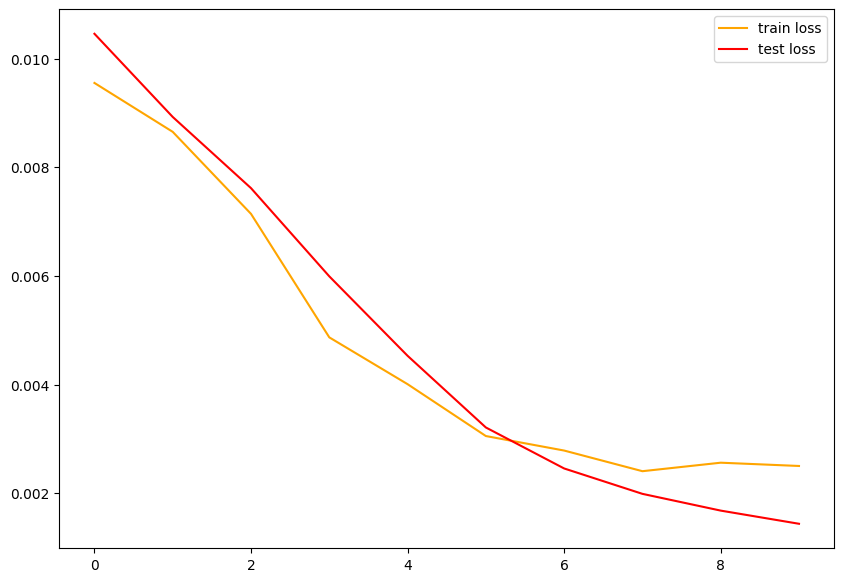

In [22]:
plt.figure(figsize=(10, 7))
plt.plot(history['test']['loss'], color='orange', label='train loss')
plt.plot(history['train']['loss'], color='red', label='test loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [23]:
def inverse_norm(img):
  img[0, :, :] = img[0, :, :] * .5 + .5
  img[1, :, :] = img[1, :, :] * .5 + .5
  img[2, :, :] = img[2, :, :] * .5 + .5

  return img

In [24]:
feature, target = next(iter(dataloaders['test']))
feature, target = feature.to(device), target.to(device)

with torch.no_grad():
    model.eval() 
    output = model(feature)
    pred_ = output.argmax(1)

pred_

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')

In [25]:
label2cat = ["female", "male"]

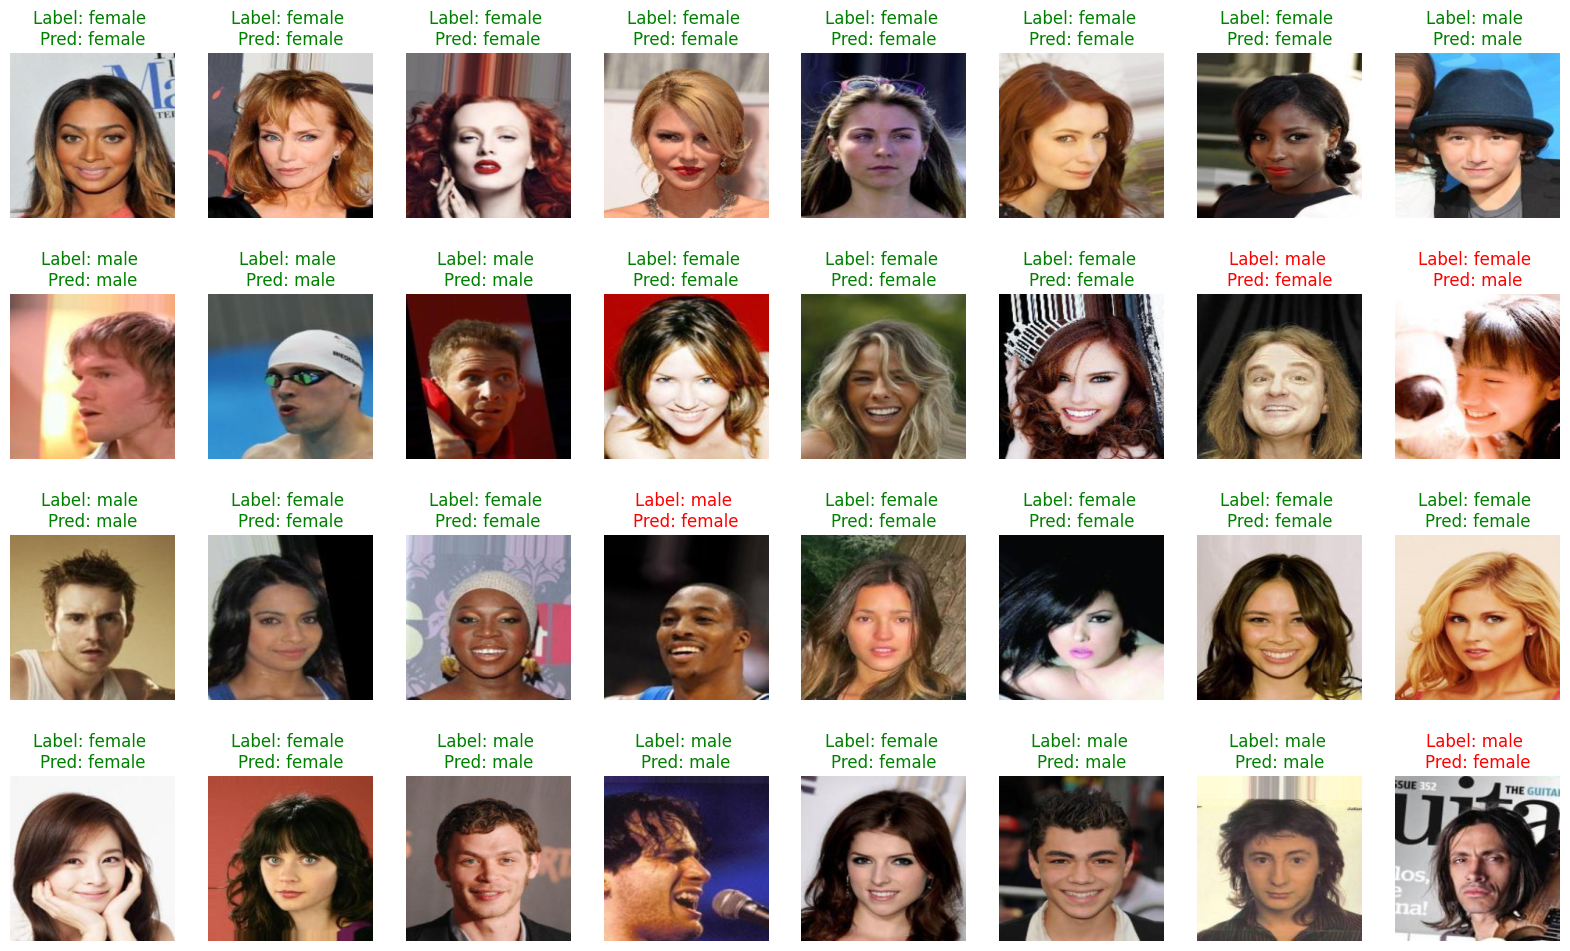

In [26]:
fig, axes = plt.subplots(4, 8, figsize = (20, 12))
for img, label, pred, ax in zip(feature, target, pred_, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1,2,0).cpu())
    font = {'color': 'r'} if label != pred else {'color' : 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label} \nPred: {pred}", fontdict = font)
    ax.axis('off')

In [27]:
#!cp best.pth /content/drive/MyDrive